## Demo for Creating and Fitting a Simulated Background via Maximum Likelihood
-------
This notebook shows how to do a maximum likelihood fit to a simulated background spectrum.

Note that we will be using the package [DarkLim](https://github.com/slwatkins/DarkLim) for generating data for our background fitting, but this package is not needed to use any features in `detprocess`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import detprocess as detp

import darklim.sensitivity as sens

%matplotlib inline

Let's define some typical parameters associated with an experiment.

In [2]:
vol_detector = 0.01 * 0.01 * 0.01 # 1 cm^3
time_elapsed = 1 # 1 day of data
efficiency = 0.8 # assume 80% efficiency of cuts/livetime
tm = 'Si' # assume a Silicon target mass

mass_det = sens.calculate_substrate_mass(vol_detector, tm=tm) # mass of the detector in kg
exposure = mass_det * time_elapsed * efficiency

energy_res = 5e-3 # energy resolution is 5 eV
threshold = 5 * energy_res # threshold if 5-sigma = 25 eV

Use `darklim.sensitivity.SensEst` to set up the experiment and create some backgrounds.

There are three types backgrounds we could add easily:
1. Flat background (energy independent)
2. Noise background (the expected background from noise events being triggered)
3. DM background (a WIMP background model)

If a different background function is to be inputted, one can use the `darklim.sensitivity.SensEst.add_arb_bkgd` method.

For now, let's simulate a flat background and a DM background. We'll simulate the background up to 0.5 keV.

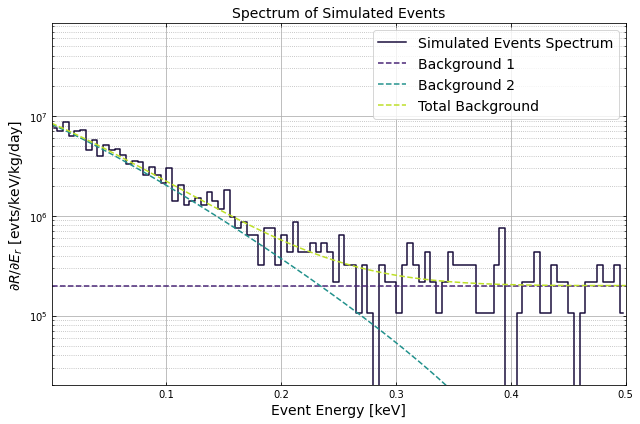

In [3]:
SE = sens.SensEst(mass_det, time_elapsed, eff=efficiency, tm=tm)

# flat background of 200000 DRU
SE.add_flat_bkgd(2e5)
# DM background for 0.5 GeV dark matter with a cross section of 1e-35 cm^2
SE.add_dm_bkgd(1, 1e-35)

gen_evts = SE.generate_background(0.5, plot_bkgd=True)

The maximum likelihood fitting methods we will use are`detprocess.NormBackground` to set up the background model and `detprocess.ext_max_llhd` to run the maximum likelihood fitting.

Note that the `NormBackground` class normalizes to a PDF. That is, the background rate is normalized to 1/\[keV\], rather than 1/\[keV kg day\].

Let's try to fit the background to a model of 1 flat background and 1 exponential background.

In [4]:
NB = detp.NormBackground(0, 0.5, flatbkgd=True, nexpbkgd=1)

Now that we have the background model set, let's run the Extended Unbinned Maximum Likelihood method. We need to give the maximum likelihood fitting starting values that are relatively close to the true values, otherwise the fitting will not be likely to converge.

Note that we multiplied the flat background and one of the exponential background components (the component that describes the overall size of the exponential background, as the other component is the characteristic energy of the exponential) by the exposure, so that we have converted to units of 1/\[keV\].

In [5]:
mm = detp.ext_max_llhd(gen_evts, NB.neglogllhd, (2e5 * exposure, 1e6 * exposure, 5e-1))

`mm` is a `Minuit` fitting object, we can access the fitted parameters (and the errors) in easy to use `numpy` arrays, as done below. There are many other useful attributes, see the `iminuit` [documentation](https://iminuit.readthedocs.io/en/stable/reference.html) for more information.

In [6]:
np.asarray(mm.values), np.asarray(mm.errors)

(array([3.38521733e+02, 1.67028949e+04, 6.70642375e-02]),
 array([6.51348876e+01, 1.10219644e+03, 4.21749224e-03]))

In this case, the units of the values are 1/\[keV\], 1/\[keV\], and \[keV\]. To convert the first two to event rate values, we would simply divide by the exposure, as done below.

In [7]:
mm.values[0] / exposure, mm.values[1] / exposure, mm.values[2]

(181641.5547639067, 8962319.136235382, 0.06706423746775828)

This says that we have a fitted flat background of roughly $2\mathrm{e}5$ events/kg/keV/day, as expected. The exponential background is of the form $f(x) = p_0 \exp ( -x / p_1)$, where the fitted parameters are $p_0 \approx 9.0\mathrm{e}6$ events/kg/keV/day and $p_1 \approx 67$ keV.

Let's plot the fitted result, to see if things make sense.

Note that we can easily use the `NormBackground.background` method to extract our background model that we inputted, passing the parameters from the fit. We also divided by the exposure to convert to units of events/kg/keV/day.

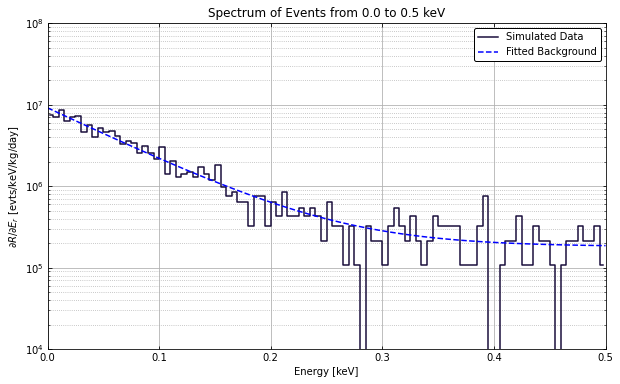

In [8]:
drde = sens.RatePlot((0, 0.5))
drde.add_data(
    gen_evts,
    exposure,
    label='Simulated Data',
)

xx = np.linspace(0, 0.5)
drde.ax.plot(
    xx,
    NB.background(xx, mm.values) / exposure,
    color='blue',
    label='Fitted Background',
    linestyle='dashed',
)

drde.ax.legend(framealpha=1, edgecolor='k')
drde.ax.set_ylim(1e4, 1e8);

Our fit appears to make sense!

Let's do one more case, where we now have a Gaussian peak in the energy range.

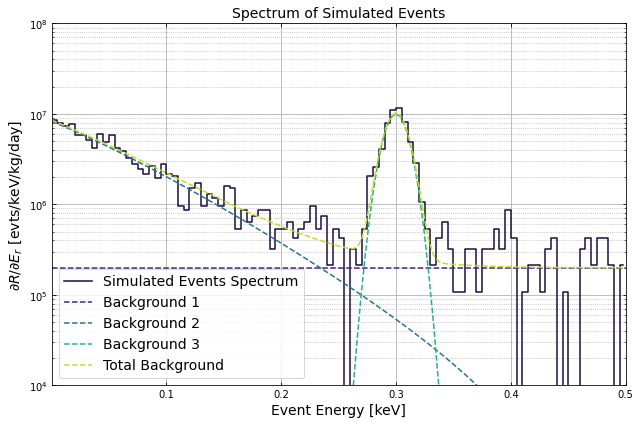

In [9]:
SE2 = sens.SensEst(mass_det, time_elapsed, eff=efficiency, tm=tm)

# flat background of 200000 DRU
SE2.add_flat_bkgd(2e5)
# DM background for 0.5 GeV dark matter with a cross section of 1e-35 cm^2
SE2.add_dm_bkgd(1, 1e-35)

# use `add_arb_bkgd` to add a Gaussian peak at 0.3 keV with a 0.01 keV width and 1e7 DRU maximum
SE2.add_arb_bkgd(lambda x: 1e7 * np.exp(-(x - 0.3)**2 / (2 * (0.01)**2)))

gen_evts2 = SE2.generate_background(0.5, plot_bkgd=True)
ax = plt.gca()
ax.set_ylim(1e4, 1e8);

Fitting this background is very similar to what we did previously, but we will add a Gaussian background to our model.

In [10]:
NB2 = detp.NormBackground(0, 0.5, flatbkgd=True, nexpbkgd=1, ngaussbkgd=1)
mm2 = detp.ext_max_llhd(gen_evts2, NB2.neglogllhd, (2e5 * exposure, 1e6 * exposure, 5e-1, 1e7 * exposure, 0.3, 0.01))
np.asarray(mm2.values), np.asarray(mm2.errors)

(array([4.59989955e+02, 1.66336416e+04, 6.32476785e-02, 2.00628326e+04,
        2.99980166e-01, 9.87398723e-03]),
 array([7.78418250e+01, 1.15825087e+03, 4.36296106e-03, 1.63943817e+03,
        6.88316217e-04, 5.51467166e-04]))

In [11]:
mm2.values[0] / exposure, mm2.values[1] / exposure, mm2.values[2], mm2.values[3] / exposure, mm2.values[4], mm2.values[5]

(246818.09892619879,
 8925159.697253304,
 0.06324767848636387,
 10765170.33475946,
 0.2999801658226381,
 0.00987398722967114)

This says that we have a fitted flat background of roughly $2.47\mathrm{e}5$ events/kg/keV/day, which is close to expectation. The exponential background is of the form $f(x) = p_0 \exp ( -x / p_1)$, where the fitted parameters are $p_0 \approx 8.9\mathrm{e}6$ events/kg/keV/day and $p_1 \approx 63$ keV. The Gaussian background parameters are roughly $1\mathrm{e}7$ events/kg/keV/day, $0.3$ keV, and $0.01$ keV. Thus, everything is as expected, especially if we look at the error bars.

Let's again check to see if things make sense.

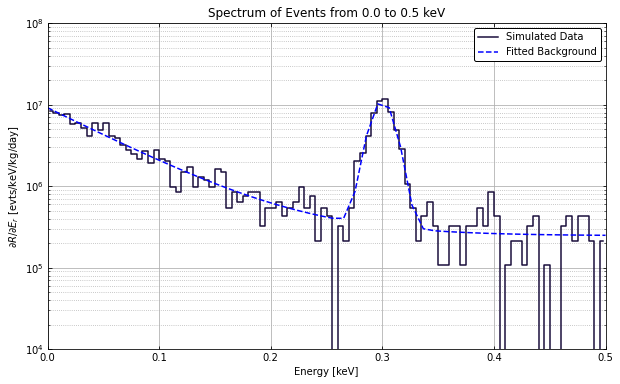

In [12]:
drde = sens.RatePlot((0, 0.5))
drde.add_data(
    gen_evts2,
    exposure,
    label='Simulated Data',
)

xx = np.linspace(0, 0.5)
drde.ax.plot(
    xx,
    NB2.background(xx, mm2.values) / exposure,
    color='blue',
    label='Fitted Background',
    linestyle='dashed',
)

drde.ax.legend(framealpha=1, edgecolor='k')
drde.ax.set_ylim(1e4, 1e8);

Awesome, the fit is just as we would expect!

See the Notes of `detprocess.ext_max_llhd` for information on the order of parameters. Note that the order always goes as (1) flat background, (2) exponential backgrounds, and (3) Gaussian backgrounds.